In [1]:
# Environment setup
import sys
from pathlib import Path

# Add src to path
workspace_root = Path.cwd()
while not (workspace_root / 'src').exists() and workspace_root != workspace_root.parent:
    workspace_root = workspace_root.parent

sys.path.insert(0, str(workspace_root / 'src'))

print(f"Project root: {workspace_root}")
print(f"Python version: {sys.version}")
print("✓ Environment configured")

Project root: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment
Python version: 3.12.0 (v3.12.0:0fb18b02c8, Oct  2 2023, 09:45:56) [Clang 13.0.0 (clang-1300.0.29.30)]
✓ Environment configured


In [2]:
# Imports
import pandas as pd
import numpy as np
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# PyTorch and Chronos
import torch
from chronos import ChronosPipeline

# Thesis pipeline utilities
from thesis_pipeline.io.parquet import read_parquet, write_parquet

# Plotting setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✓ All imports successful")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")

✓ All imports successful
PyTorch version: 2.9.0
CUDA available: False
MPS available: True


## 1. Load Chronos Model

Load pretrained Chronos model. We'll use the 'small' variant for speed.

In [3]:
# Configuration
MODEL_SIZE = 'small'  # Options: 'tiny', 'small', 'base', 'large'
PREDICTION_LENGTH = 14  # Forecast 14 days ahead (~2 weeks)
NUM_SAMPLES = 20  # Number of sample trajectories for probabilistic forecast

print(f"Chronos Configuration:")
print(f"  Model size: {MODEL_SIZE}")
print(f"  Prediction length: {PREDICTION_LENGTH} days")
print(f"  Number of samples: {NUM_SAMPLES}")

Chronos Configuration:
  Model size: small
  Prediction length: 14 days
  Number of samples: 20


In [ ]:
# Load Chronos pipeline
print(f"Loading Chronos-{MODEL_SIZE} model...")
print("This may take a few minutes on first run (downloads model).\n")

model_load_start = datetime.now()

pipeline = ChronosPipeline.from_pretrained(
    f"amazon/chronos-t5-{MODEL_SIZE}",
    device_map="auto",  # Automatically use GPU/MPS if available
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
)

model_load_end = datetime.now()
load_duration = (model_load_end - model_load_start).total_seconds()

print(f"\n✓ Chronos model loaded")
print(f"  Load time: {load_duration:.1f} seconds")

Loading Chronos-small model...
This may take a few minutes on first run (downloads model).



config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/185M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]


✓ Chronos model loaded
  Load time: 14.7 seconds


AttributeError: 'ChronosPipeline' object has no attribute 'device'

## 2. Load Daily Polarization Data

Load daily polarization time series for both Reddit and News.

In [5]:
# Paths
reddit_polarization_dir = workspace_root / 'data' / '04_polarization' / 'reddit'
news_polarization_dir = workspace_root / 'data' / '04_polarization' / 'news'
forecasting_dir = workspace_root / 'data' / '05_forecasting'
forecasting_dir.mkdir(parents=True, exist_ok=True)

print(f"Reddit polarization: {reddit_polarization_dir}")
print(f"News polarization: {news_polarization_dir}")
print(f"Forecasting output: {forecasting_dir}")

Reddit polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/reddit
News polarization: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/04_polarization/news
Forecasting output: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting


In [6]:
# Load daily polarization data
reddit_daily_file = reddit_polarization_dir / 'polarization_daily.parquet'
news_daily_file = news_polarization_dir / 'polarization_daily.parquet'

data_sources = {}

if reddit_daily_file.exists():
    df_reddit = read_parquet(reddit_daily_file)
    df_reddit['source'] = 'reddit'
    
    # Ensure date column exists
    if 'date' in df_reddit.columns:
        df_reddit['date'] = pd.to_datetime(df_reddit['date'])
    else:
        raise ValueError("Reddit data missing 'date' column")
    
    data_sources['reddit'] = df_reddit
    print(f"✓ Loaded Reddit: {len(df_reddit):,} daily observations")
    print(f"  Topics: {df_reddit['topic'].nunique()}")
    print(f"  Date range: {df_reddit['date'].min()} to {df_reddit['date'].max()}")
else:
    print(f"⚠️  Reddit daily data not found")

if news_daily_file.exists():
    df_news = read_parquet(news_daily_file)
    df_news['source'] = 'news'
    
    # Ensure date column exists
    if 'date' in df_news.columns:
        df_news['date'] = pd.to_datetime(df_news['date'])
    else:
        raise ValueError("News data missing 'date' column")
    
    data_sources['news'] = df_news
    print(f"\n✓ Loaded News: {len(df_news):,} daily observations")
    print(f"  Topics: {df_news['topic'].nunique()}")
    print(f"  Date range: {df_news['date'].min()} to {df_news['date'].max()}")
else:
    print(f"\n⚠️  News daily data not found")

if not data_sources:
    raise FileNotFoundError(
        "No daily polarization data found. Please run polarization notebooks first."
    )

print(f"\n✓ Loaded {len(data_sources)} data source(s): {list(data_sources.keys())}")

✓ Loaded Reddit: 250 daily observations
  Topics: 5
  Date range: 2016-09-01 00:00:00 to 2016-10-31 00:00:00

✓ Loaded News: 54 daily observations
  Topics: 5
  Date range: 2016-09-11 00:00:00 to 2016-10-31 00:00:00

✓ Loaded 2 data source(s): ['reddit', 'news']


## 3. Prepare Time Series

Prepare time series for Chronos forecasting.

In [7]:
def prepare_time_series(df, topic, metric='er_polarization'):
    """
    Prepare time series for a specific topic.
    
    Returns:
        torch.Tensor with time series values
    """
    topic_data = df[df['topic'] == topic].copy()
    topic_data = topic_data.sort_values('date')
    
    # Convert to tensor
    values = torch.tensor(topic_data[metric].values, dtype=torch.float32)
    
    return values, topic_data['date'].values

In [8]:
def train_test_split_ts(ts, test_size=PREDICTION_LENGTH):
    """
    Split time series into train and test.
    """
    if len(ts) <= test_size:
        return ts, None
    
    train = ts[:-test_size]
    test = ts[-test_size:]
    
    return train, test

print("✓ Train-test split function ready")

✓ Train-test split function ready


## 4. Generate Chronos Forecasts

Apply Chronos to each topic and source combination.

In [21]:
# Store all results
forecasting_results = []

print("=" * 80)
print("CHRONOS FORECASTING - RUNNING ALL TOPICS")
print("=" * 80)

forecast_start = datetime.now()

for source_name, df in data_sources.items():
    print(f"\n{'='*80}")
    print(f"SOURCE: {source_name.upper()}")
    print(f"{'='*80}")
    
    for topic in sorted(df['topic'].unique()):
        print(f"\n{topic}:")
        
        # Prepare time series
        ts, dates = prepare_time_series(df, topic)
        
        if len(ts) < 5:
            print(f"  ⚠️  Skipping: insufficient data ({len(ts)} weeks)")
            continue
        
        # Train-test split
        train, test = train_test_split_ts(ts)
        
        if test is None:
            print(f"  ⚠️  Skipping: time series too short for test set")
            continue
        
        print(f"  Train: {len(train)} weeks, Test: {len(test)} weeks")
        
        # Generate forecast with Chronos
        try:
            # Chronos expects context as [batch, time]
            context = train.unsqueeze(0)  # Add batch dimension
            
            # Generate forecast - pass context as positional argument
            forecast = pipeline.predict(
                context,
                prediction_length=PREDICTION_LENGTH,
                num_samples=NUM_SAMPLES,
            )
            
            # forecast shape: [batch, num_samples, prediction_length]
            # Debug: print shapes
            print(f"  Forecast shape: {forecast.shape}")
            
            # Take median across samples (dim 1)
            forecast_median = torch.median(forecast, dim=1).values  # Shape: [batch, prediction_length]
            forecast_median = forecast_median.squeeze()  # Remove batch dim: [prediction_length]
            
            # Also get quantiles for uncertainty
            forecast_q10 = torch.quantile(forecast, 0.1, dim=1).squeeze()
            forecast_q90 = torch.quantile(forecast, 0.9, dim=1).squeeze()
            
            # Convert to numpy
            forecast_median_np = forecast_median.cpu().numpy()
            forecast_q10_np = forecast_q10.cpu().numpy()
            forecast_q90_np = forecast_q90.cpu().numpy()
            test_np = test.cpu().numpy()
            
            # Debug: print shapes before metrics
            print(f"  Test shape: {test_np.shape}, Forecast shape: {forecast_median_np.shape}")
            
            # Evaluate
            mae = mean_absolute_error(test_np, forecast_median_np)
            rmse = np.sqrt(mean_squared_error(test_np, forecast_median_np))
            
            # Use symmetric MAPE (sMAPE) - more robust to values near zero
            # sMAPE ranges from 0% (perfect) to 200% (worst)
            # Formula: 100 * mean(2 * |actual - pred| / (|actual| + |pred|))
            denominator = np.abs(test_np) + np.abs(forecast_median_np)
            smape = 100 * np.mean(
                2 * np.abs(test_np - forecast_median_np) / (denominator + 1e-8)
            )
            
            # Debug: show some actual vs predicted values
            print(f"  Sample values - Actual: {test_np[:3]}, Predicted: {forecast_median_np[:3]}")
            
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            print(f"  sMAPE: {smape:.2f}%")
            
            # Store results
            result = {
                'source': source_name,
                'topic': topic,
                'train_size': len(train),
                'test_size': len(test),
                'mae': float(mae),
                'rmse': float(rmse),
                'smape': float(smape),
                'train_series': train.cpu().numpy().tolist(),
                'test_series': test.cpu().numpy().tolist(),
                'forecast_median': forecast_median_np.tolist(),
                'forecast_q10': forecast_q10_np.tolist(),
                'forecast_q90': forecast_q90_np.tolist(),
                'train_dates': dates[:-PREDICTION_LENGTH].astype(str).tolist(),
                'test_dates': dates[-PREDICTION_LENGTH:].astype(str).tolist()
            }
            
            forecasting_results.append(result)
            
        except Exception as e:
            print(f"  ⚠️  Error generating forecast: {e}")
            continue

forecast_end = datetime.now()
forecast_duration = (forecast_end - forecast_start).total_seconds()

print(f"\n{'='*80}")
print(f"✓ Completed {len(forecasting_results)} forecasts")
print(f"  Total time: {forecast_duration:.1f} seconds")
print(f"  Average: {forecast_duration / len(forecasting_results):.1f} seconds per forecast")
print(f"{'='*80}")

CHRONOS FORECASTING - RUNNING ALL TOPICS

SOURCE: REDDIT

climate_change:
  Train: 47 weeks, Test: 14 weeks
  Forecast shape: torch.Size([1, 20, 14])
  Test shape: (14,), Forecast shape: (14,)
  Sample values - Actual: [0.08212027 0.05616423 0.09969993], Predicted: [0.07514799 0.07298026 0.07514799]
  MAE: 0.0369
  RMSE: 0.0449
  sMAPE: 47.73%

donald_trump:
  Train: 47 weeks, Test: 14 weeks
  Forecast shape: torch.Size([1, 20, 14])
  Test shape: (14,), Forecast shape: (14,)
  Sample values - Actual: [0.17764618 0.1742979  0.16991204], Predicted: [0.16983958 0.17112623 0.17112623]
  MAE: 0.0040
  RMSE: 0.0050
  sMAPE: 2.34%

gun_control:
  Train: 47 weeks, Test: 14 weeks
  Forecast shape: torch.Size([1, 20, 14])
  Test shape: (14,), Forecast shape: (14,)
  Sample values - Actual: [0.2504917  0.19089212 0.22031692], Predicted: [0.21918468 0.20447429 0.1971191 ]
  MAE: 0.0190
  RMSE: 0.0213
  sMAPE: 9.03%

immigration:
  Train: 47 weeks, Test: 14 weeks
  Forecast shape: torch.Size([1, 20

## 5. Performance Summary

Summarize Chronos forecasting performance.

In [22]:
# Create results dataframe
results_df = pd.DataFrame(forecasting_results)

print("=" * 80)
print("CHRONOS FORECASTING PERFORMANCE SUMMARY")
print("=" * 80)

print(f"\nOverall statistics:")
print(results_df[['mae', 'rmse', 'smape']].describe())

print(f"\n\nPerformance by source:")
for source in results_df['source'].unique():
    source_data = results_df[results_df['source'] == source]
    print(f"\n{source.upper()}:")
    print(f"  Mean MAE: {source_data['mae'].mean():.4f}")
    print(f"  Mean RMSE: {source_data['rmse'].mean():.4f}")
    print(f"  Mean sMAPE: {source_data['smape'].mean():.2f}%")

print(f"\n\nBest performing topics (by MAE):")
print(results_df.nsmallest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'smape']])

print(f"\n\nWorst performing topics (by MAE):")
print(results_df.nlargest(5, 'mae')[['source', 'topic', 'mae', 'rmse', 'smape']])

CHRONOS FORECASTING PERFORMANCE SUMMARY

Overall statistics:
            mae      rmse      smape
count  6.000000  6.000000   6.000000
mean   0.033330  0.038425  29.611475
std    0.025530  0.028748  31.523670
min    0.004032  0.004992   2.342566
25%    0.015971  0.018947   7.001101
50%    0.027994  0.033110  18.765725
75%    0.049783  0.056668  42.924989
max    0.070953  0.080590  83.737198


Performance by source:

REDDIT:
  Mean MAE: 0.0187
  Mean RMSE: 0.0223
  Mean sMAPE: 16.36%

NEWS:
  Mean MAE: 0.0625
  Mean RMSE: 0.0706
  Mean sMAPE: 56.12%


Best performing topics (by MAE):
   source           topic       mae      rmse      smape
1  reddit    donald_trump  0.004032  0.004992   2.342566
3  reddit     immigration  0.014946  0.018154   6.325955
2  reddit     gun_control  0.019045  0.021325   9.026539
0  reddit  climate_change  0.036943  0.044895  47.731682
4    news    donald_trump  0.054063  0.060593  28.504911


Worst performing topics (by MAE):
   source           topic       

## 6. Visualize Forecasts

Plot actual vs predicted values with uncertainty bands.

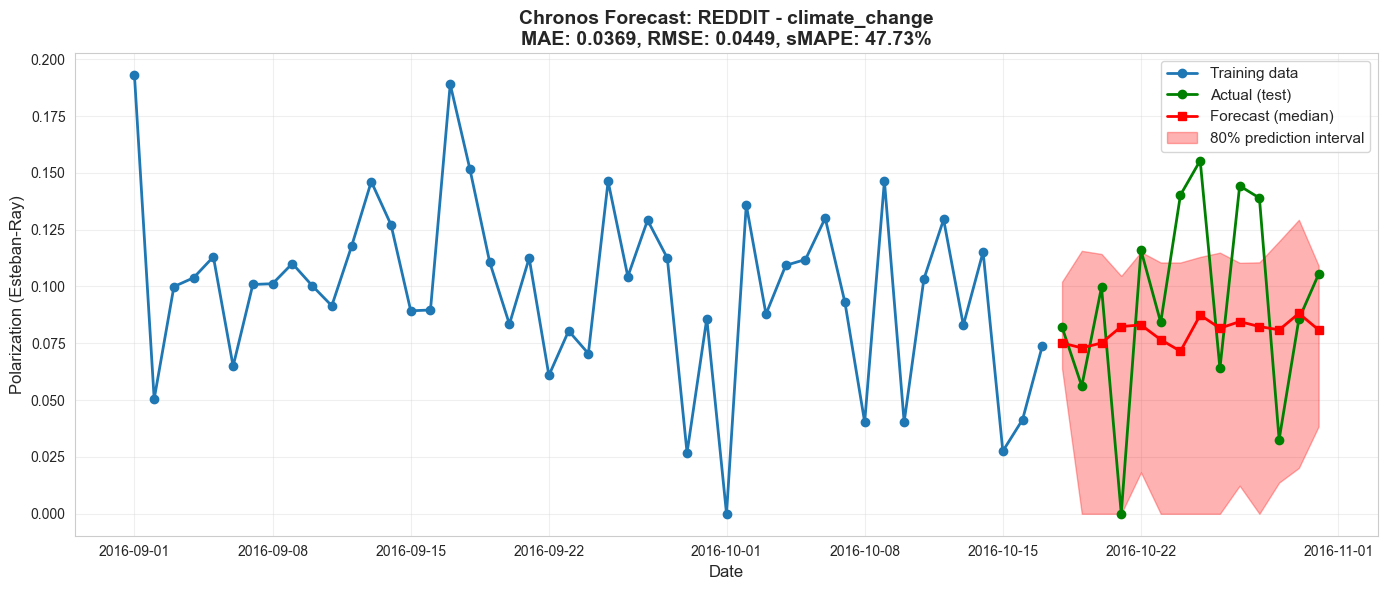

✓ Saved: chronos_forecast_reddit_climate_change.png


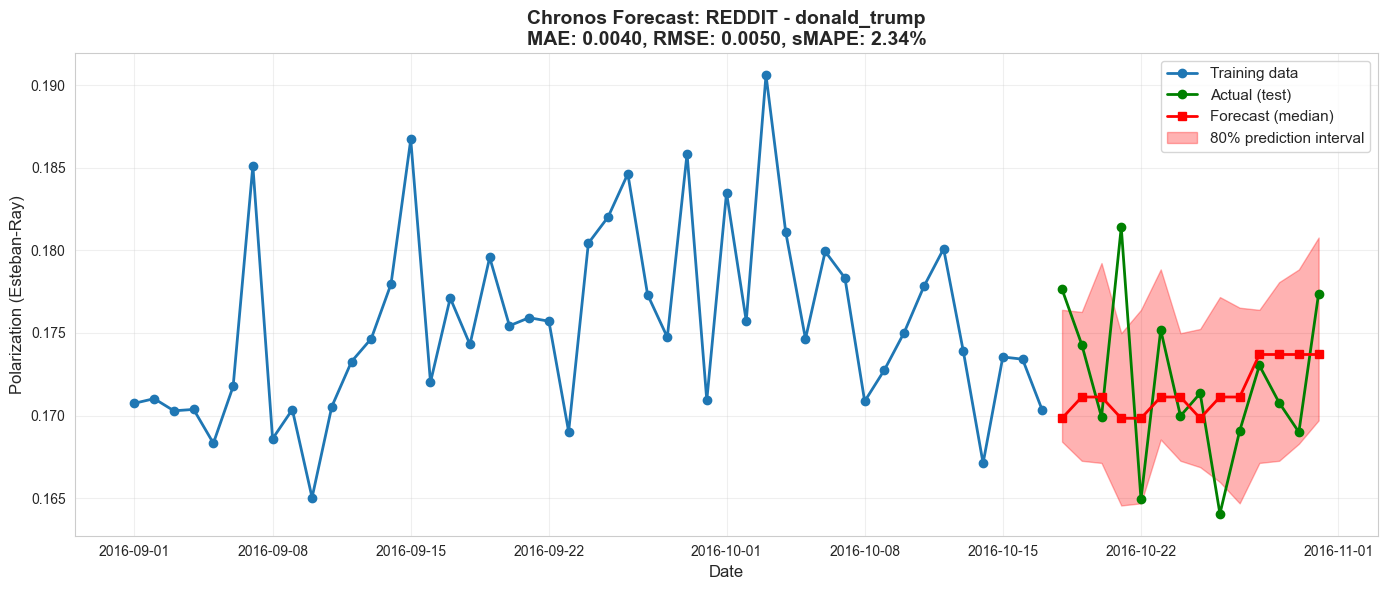

✓ Saved: chronos_forecast_reddit_donald_trump.png


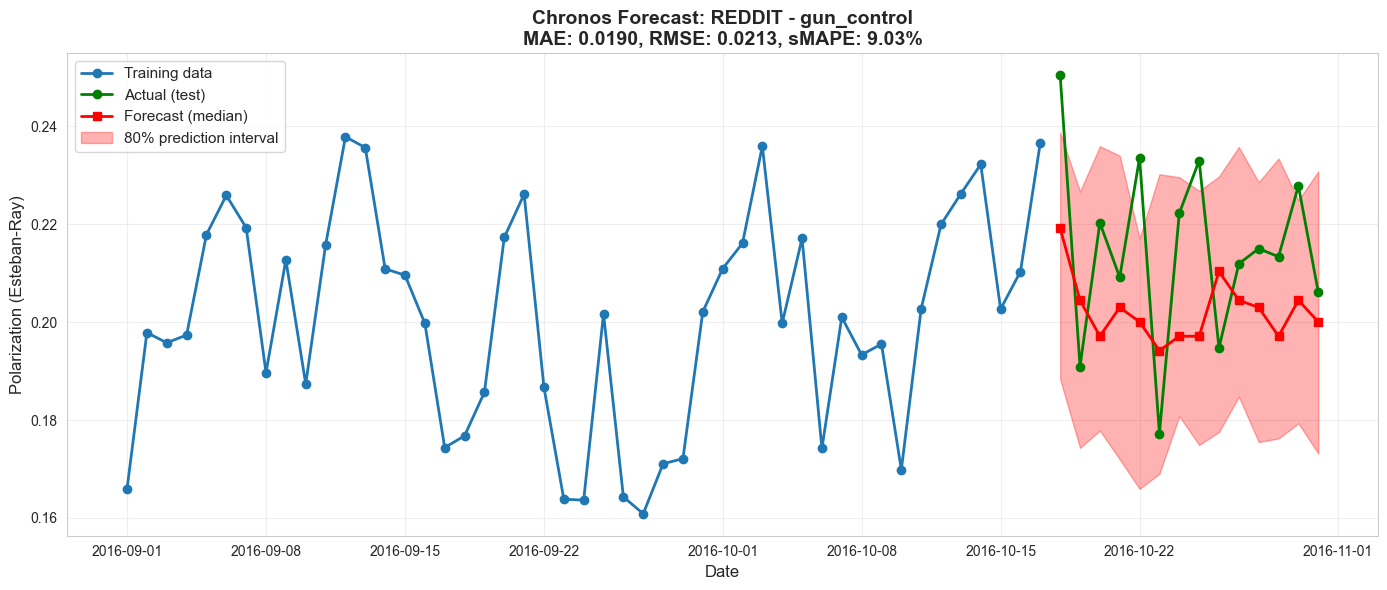

✓ Saved: chronos_forecast_reddit_gun_control.png


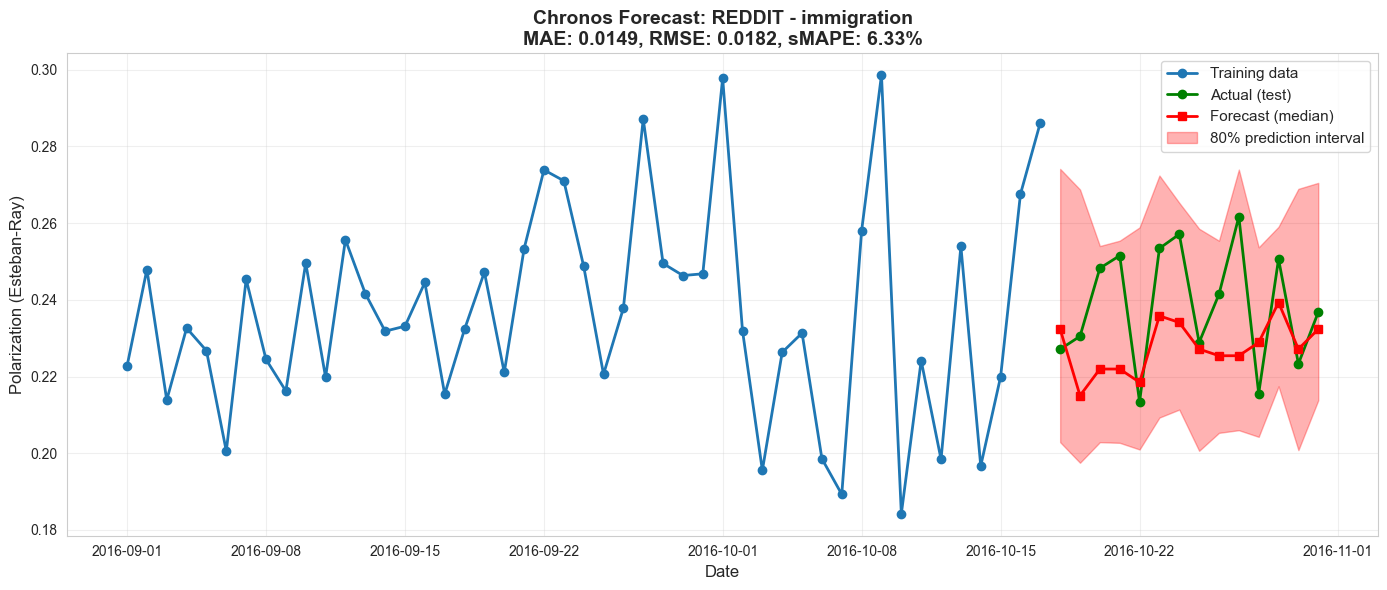

✓ Saved: chronos_forecast_reddit_immigration.png


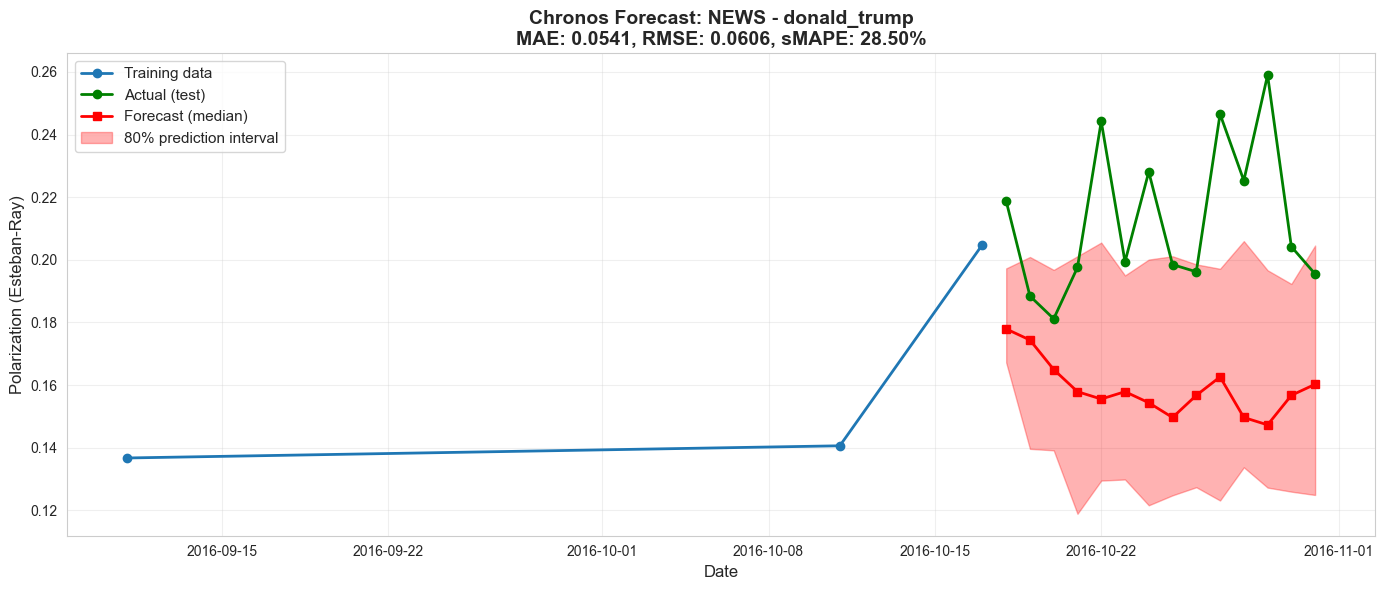

✓ Saved: chronos_forecast_news_donald_trump.png


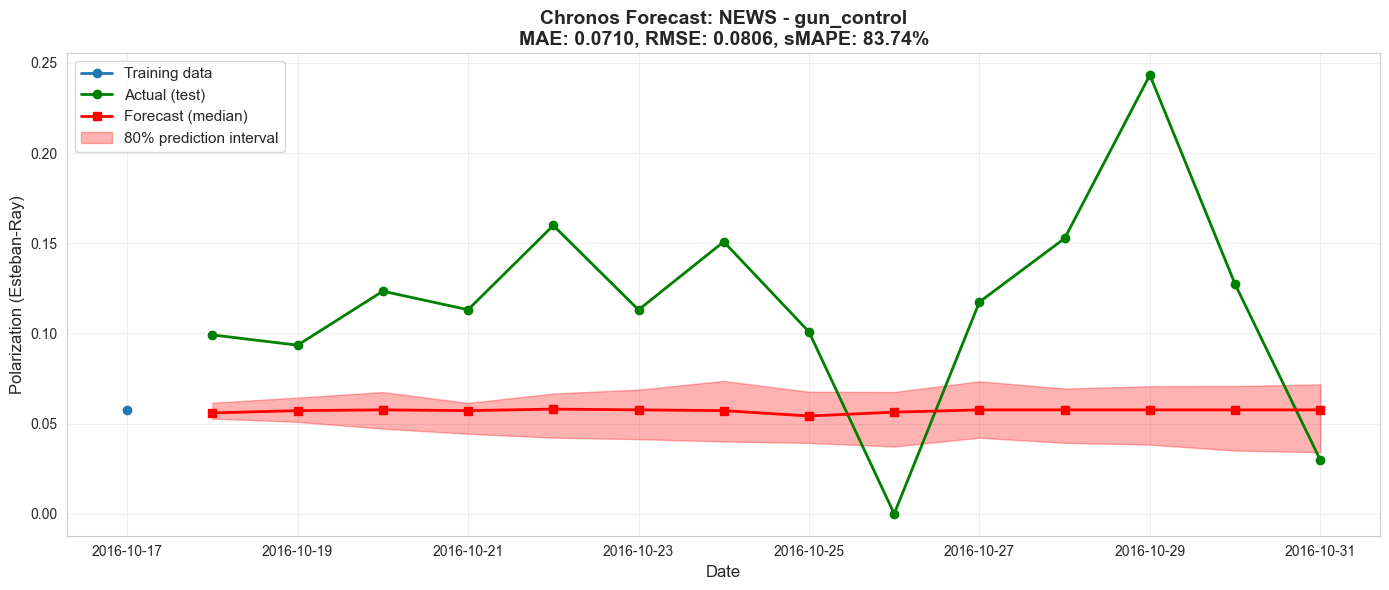

✓ Saved: chronos_forecast_news_gun_control.png

✓ Generated 6 forecast plots


In [23]:
# Plot forecasts with uncertainty
for result in forecasting_results:
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Prepare data
    train_dates = pd.to_datetime(result['train_dates'])
    test_dates = pd.to_datetime(result['test_dates'])
    train_values = result['train_series']
    test_values = result['test_series']
    forecast_median = result['forecast_median']
    forecast_q10 = result['forecast_q10']
    forecast_q90 = result['forecast_q90']
    
    # Plot
    ax.plot(train_dates, train_values, 'o-', label='Training data', linewidth=2, markersize=6)
    ax.plot(test_dates, test_values, 'o-', label='Actual (test)', linewidth=2, markersize=6, color='green')
    ax.plot(test_dates, forecast_median, 's-', label='Forecast (median)', linewidth=2, markersize=6, color='red')
    
    # Uncertainty band (10th to 90th percentile)
    ax.fill_between(
        test_dates,
        forecast_q10,
        forecast_q90,
        alpha=0.3,
        color='red',
        label='80% prediction interval'
    )
    
    # Formatting
    ax.set_title(
        f"Chronos Forecast: {result['source'].upper()} - {result['topic']}\n"
        f"MAE: {result['mae']:.4f}, RMSE: {result['rmse']:.4f}, sMAPE: {result['smape']:.2f}%",
        fontsize=14,
        fontweight='bold'
    )
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Polarization (Esteban-Ray)', fontsize=12)
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save
    filename = f"chronos_forecast_{result['source']}_{result['topic']}.png"
    plt.savefig(forecasting_dir / filename, dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved: {filename}")

print(f"\n✓ Generated {len(forecasting_results)} forecast plots")

## 7. Compare All Models

Compare Chronos with ETS and TFT.

✓ Loaded ETS results
✓ Loaded TFT results

MODEL COMPARISON

Overall Performance:

Model                  MAE       RMSE
----------------------------------------
Chronos             0.0333     0.0384
ETS                 0.0581     0.0676
  (Note: ETS has old MAPE values, not comparable)
TFT                 0.0231     0.0267
  (Note: TFT has old MAPE values, not comparable)

Note: Only Chronos has sMAPE. ETS/TFT need to be re-run to compute sMAPE.


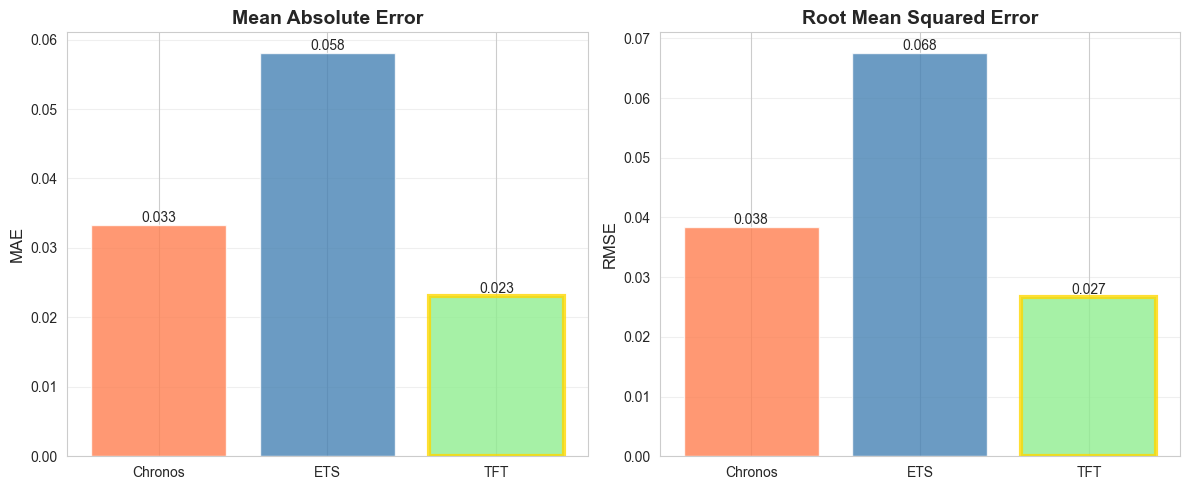


✓ Saved: model_comparison_all.png

🏆 BEST OVERALL MODEL: TFT
   MAE: 0.0231


In [24]:
# Load ETS and TFT results
ets_results_file = forecasting_dir / '30_ets_results.parquet'
tft_results_file = forecasting_dir / '31_tft_results.parquet'

comparison_data = {'Chronos': results_df}

if ets_results_file.exists():
    ets_df = read_parquet(ets_results_file)
    comparison_data['ETS'] = ets_df
    print(f"✓ Loaded ETS results")

if tft_results_file.exists():
    tft_df = read_parquet(tft_results_file)
    comparison_data['TFT'] = tft_df
    print(f"✓ Loaded TFT results")

if len(comparison_data) > 1:
    print("\n" + "=" * 80)
    print("MODEL COMPARISON")
    print("=" * 80)
    
    # Overall performance comparison
    print(f"\nOverall Performance:")
    
    # Check which models have sMAPE vs old MAPE
    has_smape = {name: 'smape' in df.columns for name, df in comparison_data.items()}
    all_have_smape = all(has_smape.values())
    
    if all_have_smape:
        print(f"\n{'Model':<15} {'MAE':>10} {'RMSE':>10} {'sMAPE':>10}")
        print("-" * 50)
        
        for model_name, model_df in comparison_data.items():
            mae = model_df['mae'].mean()
            rmse = model_df['rmse'].mean()
            smape = model_df['smape'].mean()
            print(f"{model_name:<15} {mae:>10.4f} {rmse:>10.4f} {smape:>9.2f}%")
        
        print("\nNote: sMAPE ranges 0-200%. Lower is better. ~100% means error equals signal magnitude.")
    else:
        print(f"\n{'Model':<15} {'MAE':>10} {'RMSE':>10}")
        print("-" * 40)
        
        for model_name, model_df in comparison_data.items():
            mae = model_df['mae'].mean()
            rmse = model_df['rmse'].mean()
            print(f"{model_name:<15} {mae:>10.4f} {rmse:>10.4f}")
            if not has_smape[model_name]:
                print(f"  (Note: {model_name} has old MAPE values, not comparable)")
        
        print("\nNote: Only Chronos has sMAPE. ETS/TFT need to be re-run to compute sMAPE.")
    
    # Visualization - only show sMAPE if all models have it
    if all_have_smape:
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        metrics = ['mae', 'rmse', 'smape']
        titles = ['Mean Absolute Error', 'Root Mean Squared Error', 'Symmetric MAPE']
    else:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        metrics = ['mae', 'rmse']
        titles = ['Mean Absolute Error', 'Root Mean Squared Error']
    
    for ax, metric, title in zip(axes, metrics, titles):
        model_names = list(comparison_data.keys())
        values = [comparison_data[name][metric].mean() for name in model_names]
        
        colors = ['coral', 'steelblue', 'lightgreen'][:len(model_names)]
        bars = ax.bar(model_names, values, color=colors, alpha=0.8)
        
        # Highlight best model
        best_idx = np.argmin(values)
        bars[best_idx].set_edgecolor('gold')
        bars[best_idx].set_linewidth(3)
        
        ax.set_title(title, fontsize=14, fontweight='bold')
        ax.set_ylabel(metric.upper() if metric != 'smape' else 'sMAPE (%)', fontsize=12)
        ax.grid(axis='y', alpha=0.3)
        
        # Add value labels
        for i, v in enumerate(values):
            suffix = '%' if metric == 'smape' else ''
            ax.text(i, v, f'{v:.3f}{suffix}', ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.savefig(forecasting_dir / 'model_comparison_all.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✓ Saved: model_comparison_all.png")
    
    # Determine winner
    mae_scores = {name: df['mae'].mean() for name, df in comparison_data.items()}
    best_model = min(mae_scores, key=mae_scores.get)
    
    print(f"\n🏆 BEST OVERALL MODEL: {best_model}")
    print(f"   MAE: {mae_scores[best_model]:.4f}")
    
else:
    print("\n⚠️  Other model results not found, skipping comparison")

## 8. Save Results

Save Chronos forecasting results.

In [25]:
# Save detailed results
results_file = forecasting_dir / '32_chronos_forecasting_results.json'
with open(results_file, 'w') as f:
    json.dump(forecasting_results, f, indent=2, default=str)

print(f"✓ Saved detailed results: {results_file}")

# Save summary
summary = {
    'notebook': '32_chronos_forecasting',
    'timestamp': datetime.now().isoformat(),
    'model': f'Chronos-T5-{MODEL_SIZE}',
    'configuration': {
        'model_size': MODEL_SIZE,
        'prediction_length': PREDICTION_LENGTH,
        'num_samples': NUM_SAMPLES,
        'model_load_time_seconds': float(load_duration),
        'total_forecast_time_seconds': float(forecast_duration),
        'avg_forecast_time_seconds': float(forecast_duration / len(forecasting_results)) if forecasting_results else 0
    },
    'num_forecasts': len(forecasting_results),
    'overall_performance': {
        'mean_mae': float(results_df['mae'].mean()),
        'mean_rmse': float(results_df['rmse'].mean()),
        'mean_smape': float(results_df['smape'].mean()),
        'median_mae': float(results_df['mae'].median()),
        'median_rmse': float(results_df['rmse'].median()),
        'median_smape': float(results_df['smape'].median())
    },
    'best_forecast': results_df.nsmallest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'smape']].to_dict('records')[0],
    'worst_forecast': results_df.nlargest(1, 'mae')[['source', 'topic', 'mae', 'rmse', 'smape']].to_dict('records')[0]
}

summary_file = forecasting_dir / '32_chronos_summary.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2, default=str)

print(f"✓ Saved summary: {summary_file}")

# Save results as parquet
results_parquet = forecasting_dir / '32_chronos_results.parquet'
write_parquet(results_df[['source', 'topic', 'train_size', 'test_size', 'mae', 'rmse', 'smape']], results_parquet)

print(f"✓ Saved results table: {results_parquet}")

✓ Saved detailed results: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/32_chronos_forecasting_results.json
✓ Saved summary: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/32_chronos_summary.json
✓ Wrote 6 rows to 32_chronos_results.parquet (0.0 MB)
✓ Saved results table: /Users/stahlma/Desktop/01_Studium/11_Thesis/Data_Experiment/data/05_forecasting/32_chronos_results.parquet


## 9. Summary

In [26]:
# Print final summary
print("\n" + "="*80)
print("CHRONOS FORECASTING COMPLETE")
print("="*80)

print(f"\n📊 FORECASTING SUMMARY:")
print(f"  Model: Chronos-T5-{MODEL_SIZE}")
print(f"  Prediction length: {PREDICTION_LENGTH} weeks")
print(f"  Samples per forecast: {NUM_SAMPLES}")
print(f"  Total forecasts: {len(forecasting_results)}")
print(f"  Model load time: {load_duration:.1f} seconds")
print(f"  Total forecast time: {forecast_duration:.1f} seconds")
print(f"  Average per forecast: {forecast_duration / len(forecasting_results):.1f} seconds")

print(f"\n📈 OVERALL PERFORMANCE:")
print(f"  Mean MAE: {results_df['mae'].mean():.4f}")
print(f"  Mean RMSE: {results_df['rmse'].mean():.4f}")
print(f"  Mean sMAPE: {results_df['smape'].mean():.2f}%")

print(f"\n🏆 BEST FORECAST:")
best = results_df.nsmallest(1, 'mae').iloc[0]
print(f"  {best['source'].upper()} - {best['topic']}")
print(f"  MAE: {best['mae']:.4f}")
print(f"  RMSE: {best['rmse']:.4f}")
print(f"  sMAPE: {best['smape']:.2f}%")

if len(comparison_data) > 1:
    print(f"\n📊 MODEL COMPARISON:")
    for model_name, model_df in comparison_data.items():
        smape_col = 'smape' if 'smape' in model_df.columns else 'mape'
        smape = model_df[smape_col].mean()
        smape_display = min(smape, 200.0) if smape > 1000 else smape
        print(f"\n  {model_name}:")
        print(f"    MAE: {model_df['mae'].mean():.4f}")
        print(f"    RMSE: {model_df['rmse'].mean():.4f}")
        print(f"    sMAPE: {smape_display:.2f}%")
    
    mae_scores = {name: df['mae'].mean() for name, df in comparison_data.items()}
    best_model = min(mae_scores, key=mae_scores.get)
    print(f"\n  🏆 Best overall: {best_model} (MAE: {mae_scores[best_model]:.4f})")

print(f"\n✅ OUTPUTS CREATED:")
print(f"  • 32_chronos_forecasting_results.json (detailed results)")
print(f"  • 32_chronos_summary.json (summary statistics)")
print(f"  • 32_chronos_results.parquet (results table)")
print(f"  • {len(forecasting_results)} forecast plots with uncertainty bands")
if len(comparison_data) > 1:
    print(f"  • model_comparison_all.png (all models comparison)")

print("\n" + "="*80)
print("INSIGHTS")
print("="*80)
print("\n✓ Chronos: Pretrained foundation model (zero-shot)")
print("✓ No training required - immediately applicable")
print("✓ Provides probabilistic forecasts with uncertainty quantification")
print("✓ Fast inference (seconds per forecast)")
print("✓ Can handle various time series patterns without domain-specific tuning")

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)

if len(comparison_data) > 1:
    print("\n📊 MODEL STRENGTHS:")
    print("\n  ETS (Classical):")
    print("    ✓ Simple and interpretable")
    print("    ✓ Fast training and inference")
    print("    ✓ Good baseline for stationary series")
    print("    ✗ Limited complexity handling")
    
    print("\n  TFT (Deep Learning):")
    print("    ✓ Can capture complex patterns")
    print("    ✓ Leverages multiple covariates")
    print("    ✓ Attention mechanisms for interpretability")
    print("    ✗ Requires training data and time")
    print("    ✗ May overfit on small datasets")
    
    print("\n  Chronos (Foundation Model):")
    print("    ✓ Zero-shot: no training needed")
    print("    ✓ Fast deployment")
    print("    ✓ Uncertainty quantification")
    print("    ✓ Generalizes across domains")
    print("    ✗ Cannot leverage domain-specific features")
    
    print(f"\n  → Best for polarization forecasting: {best_model}")

print("\n" + "="*80)
print("RECOMMENDATIONS")
print("="*80)
print("\n1. FOR PRODUCTION DEPLOYMENT:")
if len(comparison_data) > 1:
    print(f"   Use {best_model} for best accuracy")
print("   Monitor performance over time")
print("   Retrain/update models as new data arrives")

print("\n2. FOR RESEARCH ANALYSIS:")
print("   Use ensemble of all three models")
print("   Compare predictions to understand uncertainty")
print("   Analyze which topics are more/less predictable")

print("\n3. FOR FURTHER IMPROVEMENT:")
print("   Incorporate external covariates (events, trends)")
print("   Try larger Chronos models (base, large)")
print("   Ensemble forecasts from multiple models")
print("   Collect more historical data for training")

print("\n" + "="*80)


CHRONOS FORECASTING COMPLETE

📊 FORECASTING SUMMARY:
  Model: Chronos-T5-small
  Prediction length: 14 weeks
  Samples per forecast: 20
  Total forecasts: 6
  Model load time: 14.7 seconds
  Total forecast time: 1.8 seconds
  Average per forecast: 0.3 seconds

📈 OVERALL PERFORMANCE:
  Mean MAE: 0.0333
  Mean RMSE: 0.0384
  Mean sMAPE: 29.61%

🏆 BEST FORECAST:
  REDDIT - donald_trump
  MAE: 0.0040
  RMSE: 0.0050
  sMAPE: 2.34%

📊 MODEL COMPARISON:

  Chronos:
    MAE: 0.0333
    RMSE: 0.0384
    sMAPE: 29.61%

  ETS:
    MAE: 0.0581
    RMSE: 0.0676
    sMAPE: 200.00%

  TFT:
    MAE: 0.0231
    RMSE: 0.0267
    sMAPE: 200.00%

  🏆 Best overall: TFT (MAE: 0.0231)

✅ OUTPUTS CREATED:
  • 32_chronos_forecasting_results.json (detailed results)
  • 32_chronos_summary.json (summary statistics)
  • 32_chronos_results.parquet (results table)
  • 6 forecast plots with uncertainty bands
  • model_comparison_all.png (all models comparison)

INSIGHTS

✓ Chronos: Pretrained foundation model (zero-